# IMDB Sci-Fi project
## Projeto de análise exploratória do genero de filmes Science Ficition utilizando o IMDB.

Será usado como referência o projeto feito pela Data Science Academy no capítulo 6 do curso Python Fundamentos Para Análise de Dados 3.0.

As perguntas respondidas na análise serão:
- 1 - Número de titulos por SCI-FI?
- 2 - Mediana de Avaliação SCI-FI?
- 3 - Países que produz mais SCI-FI?
- 4 - top 10 melhores
- 5 - top 10 piores

link da referência: https://github.com/dsacademybr/PythonFundamentos

In [1]:
# Versão do Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.10.4


In [2]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

In [3]:
conn = sqlite3.connect("imdb.db")

In [4]:
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

In [5]:
tabelas = tabelas['Table_Name'].values.tolist()

In [6]:
tabelas

['people', 'titles', 'akas', 'crew', 'episodes', 'ratings']

In [7]:
for tabela in tabelas:
    consulta = f"PRAGMA TABLE_INFO({tabela})"
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




## Número de titulos por categoria no gênero SCI-FI:

Qual é a distribuição do gênero sci-fi por categoria no IMDB?

In [8]:
# Consulta SQL
consulta1 = '''SELECT type, COUNT(*) FROM titles WHERE genres LIKE '%Sci-Fi%' GROUP BY type ''' 

In [9]:
resultado = pd.read_sql_query(consulta1, conn)

In [10]:
display(resultado)

,type,COUNT(*)
0,movie,13390
1,short,26080
2,tvEpisode,50336
3,tvMiniSeries,1093
4,tvMovie,1485
5,tvSeries,4040
6,tvShort,223
7,tvSpecial,50
8,video,3242
9,videoGame,3534


In [11]:
# Remove a linha tvSpecial
resultado = resultado.drop(index = 7)

In [12]:
# filtrando as categorias < 3.5%

# Calcula o percentual
resultado['percentual'] = (resultado['COUNT(*)'] / resultado['COUNT(*)'].sum()) * 100

# Cria um dicionário vazio
others = {}

# Filtra o percentual em 5% e soma o total
others['COUNT(*)'] = resultado[resultado['percentual'] < 3.5]['COUNT(*)'].sum()

# Grava o percentual
others['percentual'] = resultado[resultado['percentual'] < 3.5]['percentual'].sum()

# Ajusta o nome
others['type'] = 'others'

# Filtra o dataframe original
resultado = resultado[resultado['percentual'] > 3.5]

# adiciona o novo tipo 'outros' no dataframe original
resultado = resultado.append(others, ignore_index = True)

In [13]:
# ordena o dataframe
resultado = resultado.sort_values(by = 'COUNT(*)', ascending = False)

In [14]:
# Legenda
labels = [str(resultado['type'][i])+' '+'['+str(round(resultado['percentual'][i],2)) +'%'+']' for i in resultado.index]

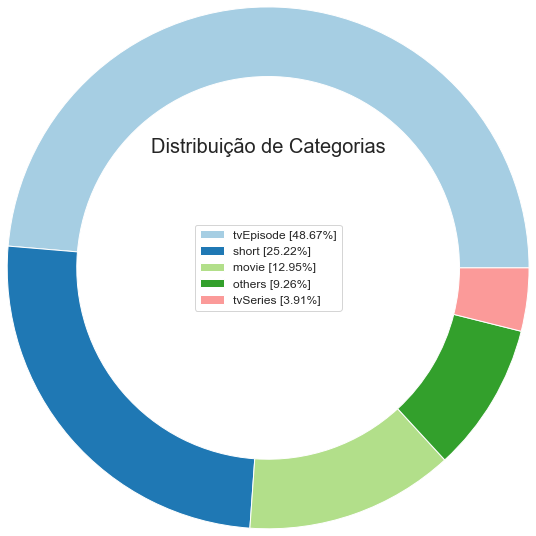

In [15]:
# Plot

# Mapa de cores
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cs = cm.Paired(np.arange(100))

# Cria a figura
f = plt.figure()

# Pie Plot
plt.pie(resultado['COUNT(*)'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Categorias", loc = 'Center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

## Mediana de Avaliação de FILMES SCI-FI:

In [16]:
# Consulta SQL
consulta2 = '''
            SELECT rating AS Rating, premiered FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered != 'NaN' AND premiered <= 2022 AND type = 'movie' AND genres LIKE '%Sci-Fi%'
            ORDER BY premiered
            ''' 

In [17]:
resultado2 = pd.read_sql_query(consulta2, conn)

In [18]:
display(resultado2)

,Rating,premiered
0,4.1,1911
1,6.4,1913
2,5.0,1913
3,3.0,1915
4,6.8,1915
...,...,...
6693,6.5,2022
6694,1.5,2022
6695,7.5,2022
6696,9.0,2022


In [19]:
# Mediana ao longo do tempo
ratings = []
for year in set(resultado2['premiered']):
    ratings.append(np.median(resultado2[resultado2['premiered'] == year]['Rating']))

In [20]:
# Anos
anos = list(set(resultado2['premiered']))

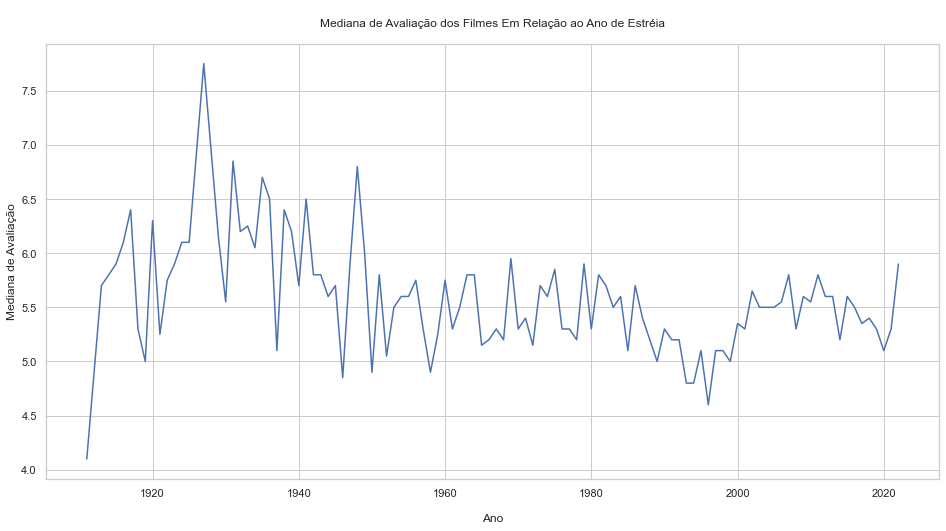

In [21]:
# Plot
plt.figure(figsize = (16,8))
plt.plot(anos, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes Em Relação ao Ano de Estréia\n')
plt.show()

## Número de filmes SCI-FI avaliados por ano:

In [22]:
# Consulta SQL
consulta3 = '''SELECT premiered, COUNT(premiered) FROM titles WHERE type = 'movie' AND genres LIKE '%Sci-Fi%' AND premiered <= 2022 GROUP BY premiered ''' 

In [23]:
# Resultado
resultado3 = pd.read_sql_query(consulta3, conn)

In [24]:
display(resultado3)

,premiered,COUNT(premiered)
0,1911,1
1,1913,2
2,1915,5
3,1916,8
4,1917,2
...,...,...
103,2018,393
104,2019,346
105,2020,387
106,2021,443


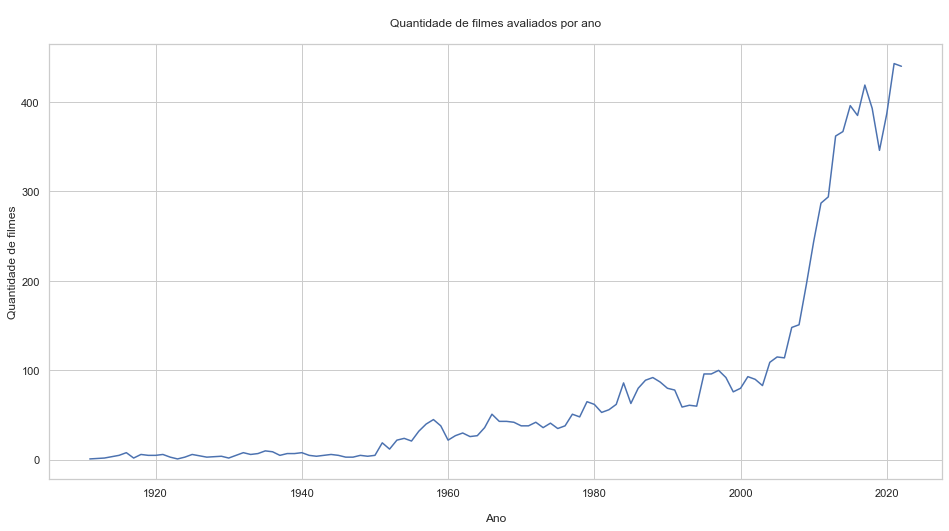

In [25]:
# Plot
plt.figure(figsize = (16,8))
plt.plot(resultado3['premiered'], resultado3['COUNT(premiered)'])
plt.xlabel('\nAno')
plt.ylabel('Quantidade de filmes')
plt.title('\nQuantidade de filmes avaliados por ano\n')
plt.show()

## Percentil do número de filmes Produzidos Por País?


In [26]:
# Consulta sql
consulta4 = '''
            SELECT region, COUNT(*) Number_of_movies FROM 
            akas JOIN titles ON 
            akas.title_id = titles.title_id
            WHERE region != 'None'
            AND type = \'movie\'
            AND genres LIKE '%Sci-Fi%'
            GROUP BY region
            ''' 

In [27]:
resultado4 = pd.read_sql_query(consulta4, conn)

In [28]:
display(resultado4)

,region,Number_of_movies
0,AD,1
1,AE,454
2,AF,2
3,AL,31
4,AM,10
...,...,...
136,XWW,1566
137,XYU,110
138,YE,1
139,YUCS,2


In [29]:
# Listas auxiliares
nomes_paises = []
contagem = []

In [30]:
# Loop para obter o país de acordo com a região
for i in range(resultado4.shape[0]):
    try:
        coun = resultado4['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado4['Number_of_movies'].values[i])
    except: 
        continue

In [31]:
# Prepara o dataframe
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem

In [32]:
# Ordena o resultado
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = False)

In [33]:
# Visualiza
df_filmes_paises.head(10)

,country,Movie_Count
123,United States,11868
43,United Kingdom,5608
21,Canada,4034
63,Japan,2878
42,France,2749
40,Spain,2741
33,Germany,2664
46,Greece,2402
18,Brazil,2388
60,Italy,2214


In [34]:
df_filmes_paises['percentual'] = (df_filmes_paises['Movie_Count'] / df_filmes_paises['Movie_Count'].sum()) * 100

In [35]:
df_filmes_paises

,country,Movie_Count,percentual
123,United States,11868,15.873738
43,United Kingdom,5608,7.500836
21,Canada,4034,5.395573
63,Japan,2878,3.849395
42,France,2749,3.676854
...,...,...,...
68,Kuwait,1,0.001338
111,San Marino,1,0.001338
49,Honduras,1,0.001338
51,Haiti,1,0.001338


In [51]:
others = {}
# cria a linha OTHERS
others['Movie_Count'] = df_filmes_paises[df_filmes_paises['percentual'] < 3]['Movie_Count'].sum()
others['percentual'] = df_filmes_paises[df_filmes_paises['percentual'] < 3]['percentual'].sum()
others['country'] = 'others'

In [50]:
# filtra os países
df_filmes_paises = df_filmes_paises[df_filmes_paises['percentual'] > 3]

In [39]:
df_filmes_paises = df_filmes_paises.append(others, ignore_index = True)

In [40]:
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = True)

In [41]:
df_filmes_paises.head(10)

,country,Movie_Count,percentual
8,Brazil,2388,3.194008
7,Greece,2402,3.212733
6,Germany,2664,3.563165
5,Spain,2741,3.666154
4,France,2749,3.676854
3,Japan,2878,3.849395
2,Canada,4034,5.395573
1,United Kingdom,5608,7.500836
0,United States,11868,15.873738
9,others,37433,50.067545


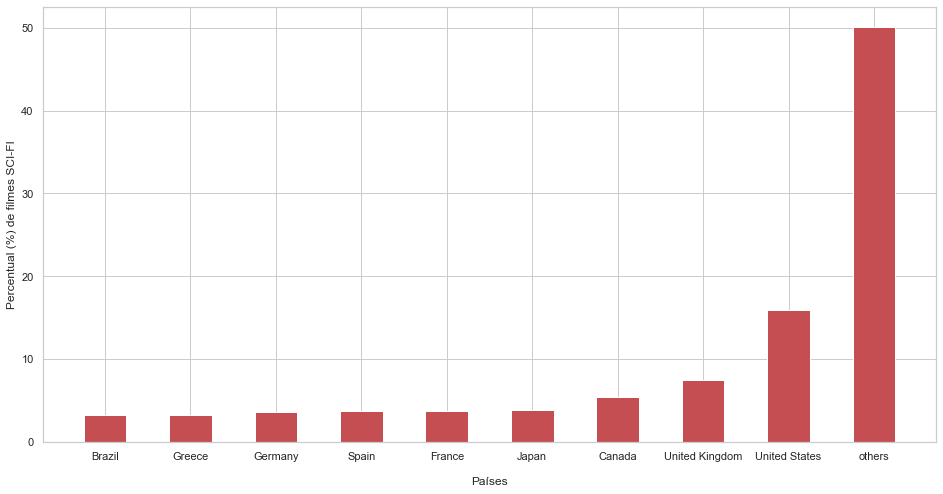

In [49]:
# Plot

cs = cm.Paired(np.arange(100))
f = plt.figure(figsize = (16, 8))
plt.bar(df_filmes_paises['country'], df_filmes_paises['percentual'], color ='r', width = 0.5)
plt.xlabel("\nPaíses")
plt.ylabel("Percentual (%) de filmes SCI-FI")
plt.title("")
plt.show()

## Top 10 melhores e piores filmes SCI-FI IMDB

In [43]:
# Consulta SQL
consulta5 = '''
            SELECT primary_title AS Movie_Name, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000 AND titles.genres LIKE '%Sci-Fi%'
            ORDER BY rating DESC
            LIMIT 10          
            ''' 

In [44]:
resultado5 = pd.read_sql_query(consulta5, conn)

### Top 10 melhores

In [45]:
display(resultado5)

,Movie_Name,rating
0,Inception,8.8
1,The Matrix,8.7
2,Terminator 2: Judgment Day,8.6
3,Interstellar,8.6
4,Alien,8.5
5,Back to the Future,8.5
6,The Prestige,8.5
7,Aliens,8.4
8,Avengers: Infinity War,8.4
9,Metropolis,8.3


In [46]:
# Consulta SQL
consulta6 = '''
            SELECT primary_title AS Movie_Name, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000 AND titles.genres LIKE '%Sci-Fi%'
            ORDER BY rating ASC
            LIMIT 10          
            ''' 

In [47]:
resultado6 = pd.read_sql_query(consulta6, conn)

## Top 10 piores filmes

In [48]:
display(resultado6)

,Movie_Name,rating
0,Superbabies: Baby Geniuses 2,1.5
1,Disaster Movie,1.9
2,Alone in the Dark,2.4
3,Battlefield Earth,2.5
4,Rollerball,3.1
5,Left Behind,3.1
6,Barb Wire,3.5
7,Superman IV: The Quest for Peace,3.7
8,Batman & Robin,3.7
9,The Avengers,3.8
